In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
from six.moves import cPickle as pickle
%matplotlib inline

/home/josh/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Read the training data

In [2]:
#pickle_file = 'train.pickle'
'''
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X_1 = save['data']
    train_outcome_1 = save['outcome']
    del save  # hint to help gc free up memory
'''
    
pickle_file = 'train2.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X_0 = save['data']
    train_outcome_0 = save['outcome']
    del save  # hint to help gc free up memory
    
'''
pickle_file = 'test.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_X_1 = save['data']
    test_outcome_1 = save['outcome']
    del save  # hint to help gc free up memory
    
'''

pickle_file = 'test2.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_X_0 = save['data']
    test_outcome_0 = save['outcome']
    del save  # hint to help gc free up memory

In [3]:
#reformat the label
#for each digit, add a 'end_digit' as '10'
#for each label, add a digit size
#each of them is a one-hot coding

def label_reformat(label, max_size = 5):
    digit_size = np.asarray([len(x) for x in label])
    digit_size[digit_size > max_size]= max_size
    digit_size = ((np.arange(max_size)+1) == digit_size[:,None]).astype(np.float32)
    
    digits = {}
    end_digit = 10.0
    for i in range(max_size):
        digit_coding = np.asarray( [x[i] if len(x)>i else end_digit for x in label])
        digit_coding = (np.arange(end_digit+1) == digit_coding[:,None]).astype(np.float32)
        digits['digit_'+ str(i)] = digit_coding
        
    return digit_size, digits   

# sample a smaller data

In [4]:
#train_X_0 = np.vstack((train_X_1 ,train_X_2 ))

In [5]:
train_X_0.shape

(33402, 64, 64, 3)

In [6]:
#train_X_0 = np.vstack((train_X_1 ,train_X_2 ))

image_size = train_X_0.shape[1]
num_channels = train_X_0.shape[3]
batch_size = 200
val_size = 50
test_size = 50


#train_label = train_outcome_1['label'] +  train_outcome_2['label']
train_label = train_outcome_0['label']
train_digit_size, train_digits = label_reformat(train_label)
train_X = train_X_0


val_label = test_outcome_0['label']
val_digit_size, val_digits = label_reformat(val_label)
val_X = test_X_0

val_size = val_X.shape[0]

In [7]:
print train_digit_size.shape
print train_digits['digit_0'].shape
print train_X.shape

(33402, 5)
(33402, 11)
(33402, 64, 64, 3)


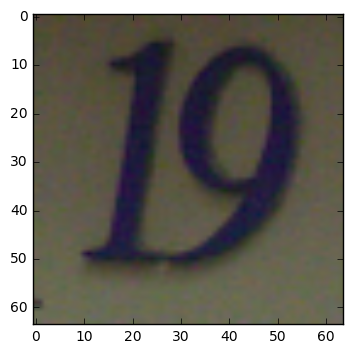

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


In [8]:
plt.imshow(train_X[0,:,:,:])
plt.show()
print train_digits['digit_0'][0]
print train_digits['digit_1'][0]

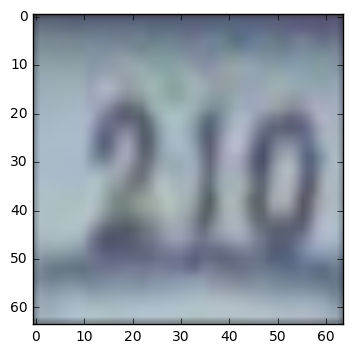

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [9]:
plt.imshow(val_X[1,:,:,:])
plt.show()
print val_digits['digit_0'][1]
print val_digits['digit_1'][1]

# start tensorflow session

In [10]:
def next_batch(X, y_dsize, y_ds, batch_size=50, replace = True):
    idx = np.random.choice(X.shape[0],batch_size, replace = replace)
    batch_x = X[idx,:,:,:]
    batch_y_dsize = y_dsize[idx,:]
    batch_y_d1 = y_ds['digit_0'][idx,:]
    batch_y_d2 = y_ds['digit_1'][idx,:]
    batch_y_d3 = y_ds['digit_2'][idx,:]
    batch_y_d4 = y_ds['digit_3'][idx,:]
    batch_y_d5 = y_ds['digit_4'][idx,:]
    
    return batch_x, batch_y_dsize, batch_y_d1, batch_y_d2, batch_y_d3, batch_y_d4, batch_y_d5


In [13]:

graph = tf.Graph()
with graph.as_default():
    
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def max_pool_2x2(x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    x_image = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))

    y_d1 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    y_d2 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    y_d3 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    y_d4 = tf.placeholder(tf.float32, shape=(batch_size, 11))
    y_d5 = tf.placeholder(tf.float32, shape=(batch_size, 11))

    y_dsize = tf.placeholder(tf.float32, shape=(batch_size, 5))
    
    val_x_image = tf.placeholder(tf.float32, shape=(val_size, image_size, image_size, num_channels))

    val_y_d1 = tf.placeholder(tf.float32, shape=(val_size, 11))
    val_y_d2 = tf.placeholder(tf.float32, shape=(val_size, 11))
    val_y_d3 = tf.placeholder(tf.float32, shape=(val_size, 11))
    val_y_d4 = tf.placeholder(tf.float32, shape=(val_size, 11))
    val_y_d5 = tf.placeholder(tf.float32, shape=(val_size, 11))

    val_y_dsize = tf.placeholder(tf.float32, shape=(val_size, 5))

    test_x_image = tf.placeholder(tf.float32, shape=(test_size, image_size, image_size, num_channels))

    test_y_d1 = tf.placeholder(tf.float32, shape=(test_size, 11))
    test_y_d2 = tf.placeholder(tf.float32, shape=(test_size, 11))
    test_y_d3 = tf.placeholder(tf.float32, shape=(test_size, 11))
    test_y_d4 = tf.placeholder(tf.float32, shape=(test_size, 11))
    test_y_d5 = tf.placeholder(tf.float32, shape=(test_size, 11))

    test_y_dsize = tf.placeholder(tf.float32, shape=(test_size, 5))
    
    
    W_conv1 = weight_variable([5, 5, num_channels, 32])
    b_conv1 = bias_variable([32])

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    W_fc1 = weight_variable([16 * 16 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 16*16*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    #W_conv3 = weight_variable([5, 5, 64, 256])
    #b_conv3 = bias_variable([256])

    #h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    #h_pool3 = max_pool_2x2(h_conv3)
    
    #W_fc1 = weight_variable([8 * 8 * 256, 1024])
    #b_fc1 = bias_variable([1024])

    #h_pool3_flat = tf.reshape(h_pool3, [-1, 8*8*256])
    #h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
    
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    
    #first digit
    W_fc2_d1 = weight_variable([1024, 11])
    b_fc2_d1 = bias_variable([11])

    y_conv_d1 = tf.matmul(h_fc1_drop, W_fc2_d1) + b_fc2_d1

    #second digit
    W_fc2_d2 = weight_variable([1024, 11])
    b_fc2_d2 = bias_variable([11])

    y_conv_d2 = tf.matmul(h_fc1_drop, W_fc2_d2) + b_fc2_d2

    #third digit
    W_fc2_d3 = weight_variable([1024, 11])
    b_fc2_d3 = bias_variable([11])

    y_conv_d3 = tf.matmul(h_fc1_drop, W_fc2_d3) + b_fc2_d3

    #fourth digit
    W_fc2_d4 = weight_variable([1024, 11])
    b_fc2_d4 = bias_variable([11])

    y_conv_d4 = tf.matmul(h_fc1_drop, W_fc2_d4) + b_fc2_d4

    #fifth digit
    W_fc2_d5 = weight_variable([1024, 11])
    b_fc2_d5 = bias_variable([11])

    y_conv_d5 = tf.matmul(h_fc1_drop, W_fc2_d5) + b_fc2_d5

    #digit size
    W_fc2_dsize = weight_variable([1024, 5])
    b_fc2_dsize = bias_variable([5])

    y_conv_dsize = tf.matmul(h_fc1_drop, W_fc2_dsize) + b_fc2_dsize

    
    cross_entropy = ( tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d1, y_d1)) 
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d2, y_d2))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d3, y_d3))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d4, y_d4))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_d5, y_d5))
                     + tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv_dsize, y_dsize))
                     )

    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    
    
    #let's just check the first digit
    #correct_prediction = tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1)) 
    correct_prediction = ( tf.cast( tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1)) , tf.float32) 
                          * tf.cast( tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1)) , tf.float32)
                          * tf.cast( tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1)) , tf.float32)
                          * tf.cast( tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1)) , tf.float32)
                          * tf.cast( tf.equal(tf.argmax(y_conv_d1,1), tf.argmax(y_d1,1)) , tf.float32)
                          )
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    

# Train model on a small data, see whether it overfit 
if overfit, then good. If not, check bugs.

In [21]:
num_steps = 50000
summary_frequency = 50


tr_acc, ts_acc = [], []

with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run()
    print('Initialized')

    for i in range(num_steps):
        (batch_x, batch_y_dsize, 
         batch_y_d1, batch_y_d2, 
         batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(train_X, 
                                                          train_digit_size, 
                                                          train_digits, batch_size)
        feed_dict={
                x_image: batch_x, y_dsize: batch_y_dsize,
                y_d1: batch_y_d1, y_d2: batch_y_d2, y_d3: batch_y_d3,
                y_d4: batch_y_d4, y_d5: batch_y_d5,
                keep_prob: 0.5}
        
        session.run(train_step,feed_dict=feed_dict)
    
        if i%summary_frequency == 0:
            train_accuracy = accuracy.eval(feed_dict=feed_dict)
            print("step %d, training accuracy %g"%(i, train_accuracy))
            tr_acc.append(train_accuracy)
        
        #if i%(summary_frequency*10) ==0:
            (batch_x, batch_y_dsize, 
             batch_y_d1, batch_y_d2, 
             batch_y_d3, batch_y_d4, batch_y_d5) = next_batch(val_X, 
                                                              val_digit_size, 
                                                              val_digits, batch_size)
            val_accuracy = accuracy.eval(feed_dict={
                        x_image: batch_x, y_dsize: batch_y_dsize,
                        y_d1: batch_y_d1, y_d2: batch_y_d2, y_d3: batch_y_d3,
                        y_d4: batch_y_d4, y_d5: batch_y_d5,
                        keep_prob: 1.0})
            ts_acc.append(val_accuracy)
            print("step %d, val accuracy %g"%(i, val_accuracy))
        
tr_acc, ts_acc = np.array(tr_acc), np.array(ts_acc)


Initialized
step 0, training accuracy 0.125
step 0, val accuracy 0.105
step 50, training accuracy 0.235
step 50, val accuracy 0.27
step 100, training accuracy 0.22
step 100, val accuracy 0.27
step 150, training accuracy 0.24
step 150, val accuracy 0.325
step 200, training accuracy 0.25
step 200, val accuracy 0.27
step 250, training accuracy 0.27
step 250, val accuracy 0.32
step 300, training accuracy 0.24
step 300, val accuracy 0.36
step 350, training accuracy 0.27
step 350, val accuracy 0.3
step 400, training accuracy 0.26
step 400, val accuracy 0.3
step 450, training accuracy 0.29
step 450, val accuracy 0.305
step 500, training accuracy 0.285
step 500, val accuracy 0.29
step 550, training accuracy 0.26
step 550, val accuracy 0.405
step 600, training accuracy 0.335
step 600, val accuracy 0.395
step 650, training accuracy 0.315
step 650, val accuracy 0.355
step 700, training accuracy 0.285
step 700, val accuracy 0.34
step 750, training accuracy 0.39
step 750, val accuracy 0.375
step 80

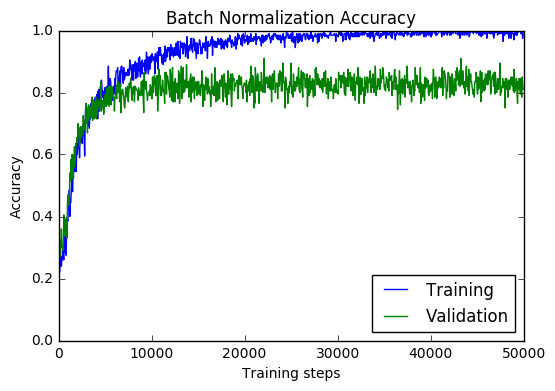

In [22]:
fig, ax = plt.subplots()

ax.plot(range(0,len(tr_acc)*summary_frequency,summary_frequency),tr_acc, label='Training')
ax.plot(range(0,len(ts_acc)*summary_frequency,summary_frequency),ts_acc, label='Validation')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()